## 1. 필요한 라이브러리 임포트 및 환경 설정

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. BigQuery 연결

In [2]:
# BigQuery 클라이언트 초기화
def get_bigquery_client():
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    return bigquery.Client(credentials=credentials, project=credentials.project_id)

client = get_bigquery_client()


# ADX와 Chaikin 지표를 포함한 데이터 로드 함수
def get_stock_data_with_indicators(ticker, start_date=None, end_date=None):
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        -- 가격 데이터
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        
        -- ADX 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.adx_14_values') AS adx_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.pdi_14_values') AS pdi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.mdi_14_values') AS mdi_14_values_array,
        
        -- Chaikin Oscillator 관련 지표 (수정된 필드명)
        JSON_EXTRACT_ARRAY(data, '$.chaikin_oscillator') AS chaikin_oscillator_array,
        JSON_EXTRACT_ARRAY(data, '$.chaikin_9_signal_line') AS chaikin_signal_array,

        -- MACD 관련
        JSON_EXTRACT_ARRAY(data, '$.macd_line') AS macd_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_9_signal_line') AS macd_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_histogram') AS macd_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_signals') AS macd_signals_array,
        
        -- Stochastic
        JSON_EXTRACT_ARRAY(data, '$.stochastic_k_line') AS stochastic_k_line_array,
        JSON_EXTRACT_ARRAY(data, '$.stochastic_d_line') AS stochastic_d_line_array,
        
        -- OBV 관련
        JSON_EXTRACT_ARRAY(data, '$.obv_values') AS obv_values_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_9_ma') AS obv_9_ma_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_signals') AS obv_signals_array,

        -- RSI 관련
        JSON_EXTRACT_ARRAY(data, '$.rsi_14_values') AS rsi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_9_signal_line') AS rsi_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_histogram') AS rsi_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_signals') AS rsi_signals_array,
              
        -- ATR 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.atr') AS atr_array,

        -- 배열 길이
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
        
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),
    indices AS (
      SELECT r.ticker, pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )
    SELECT 
      -- 날짜와 가격 데이터
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume,
      
      -- RSI 관련
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.rsi_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS rsi_signals,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      
      -- ATR 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.atr_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.atr_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS atr,
      -- ADX 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.adx_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.adx_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS adx_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.pdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.pdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS pdi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.mdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.mdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS mdi_14,
      
      -- Chaikin Oscillator (수정된 필드명)
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_oscillator_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_oscillator_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_oscillator,
      
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_signal_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_signal_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_signal,

      -- Stochastic
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_k_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_k_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_k_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_d_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_d_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_d_line,

      -- MACD 관련
      CASE 
        WHEN ARRAY_LENGTH(r.macd_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      -- OBV 관련
      CASE 
        WHEN ARRAY_LENGTH(r.obv_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_values_array[OFFSET(i.pos)], '$') AS INT64)
        ELSE NULL 
      END AS obv_values,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_9_ma_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_9_ma_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS obv_9_ma,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.obv_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS obv_signals

    FROM raw_data r
    CROSS JOIN indices i
    WHERE i.ticker = r.ticker {date_filter}
    ORDER BY date DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        # Chaikin의 전일 값 계산
        df['chaikin_yesterday'] = df['chaikin_oscillator'].shift(1)

        print(f"✅ {ticker} 데이터 로드 완료: {len(df)}개 레코드")
        return df
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

## 3. ATR 기반 백테스트 전략 함수 정의

### 함수1

In [22]:
# ATR 계산 함수
def calculate_atr(df, period=14):
    """
    ATR (Average True Range) 계산
    
    Parameters:
    - df: DataFrame with 'high', 'low', 'close' columns
    - period: ATR 계산 기간 (기본 14)
    
    Returns:
    - Series: ATR values
    """
    # True Range 계산
    high_low = df['high'].shift(1) - df['low'].shift(1)
    high_close = np.abs(df['high'].shift(1) - df['close'].shift(2))
    low_close = np.abs(df['low'].shift(1) - df['close'].shift(2))
    
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    # ATR 계산 (단순이동평균)
    atr = tr.rolling(window=period).mean()
    
    return atr


### 함수2 : 매수매도

In [109]:
def backtest_atr_strategy(ticker, df, initial_capital=100000, 
                         atr_entry_multiplier=0.5,  # ATR의 몇 배 이상 움직이면 매수
                         stop_loss_atr=1.5,         # 손절선: ATR의 몇 배
                         take_profit_atr=3.0,       # 익절선: ATR의 몇 배
                         position_size_atr=2.0,     # 포지션 사이징: 자본금의 2%를 ATR 1배로 나눔
                         commission_rate=0.001,     # 거래수수료 0.1%
                         slippage_rate=0.001,      # 슬리피지 0.1%
                         atr_period=14,            # ATR 계산 기간
                         capital_ratio=0.5,
                         position_sizing=0.02):
    """
    ATR 기반 변동성 돌파 전략 백테스트
    
    매수 조건 (현실적인 접근):
    1. 어제 ATR 기반으로 오늘 변동성 돌파 가격 설정
    2. 돌파가격 = 오늘 시가 + (어제 ATR * multiplier)
    3. 오늘 고가가 돌파가격을 상향 돌파하면 매수
    
    포지션 사이징:
    - 리스크 = 자본금의 2%
    - 포지션 크기 = 리스크 / (ATR * stop_loss_atr)
    
    청산 조건:
    1. 손절: 매수가 - (ATR * stop_loss_atr)
    2. 익절: 매수가 + (ATR * take_profit_atr)
    """
    
    # ATR 계산 (calculate_atr 함수 사용)
    df = df.copy()  # 원본 데이터프레임 보호
    df['atr'] = calculate_atr(df, period=atr_period)
    
    # 전일 ATR 추가
    df['prev_atr'] = df['atr'].shift(1)
    
    # 백테스트 결과 저장용 변수
    cash = initial_capital
    position = 0
    entry_price = 0
    entry_atr = 0
    trades = []
    
    # 일별 수익률 및 포트폴리오 가치
    portfolio_values = []
    daily_returns = []
    positions = []  # 매일의 포지션 수
    
    for i in range(len(df)):
        date = df.index[i]
        row = df.iloc[i]
        
        # 첫날이거나 전일 ATR이 없으면 스킵
        if i == 0 or pd.isna(row['prev_atr']) or row['prev_atr'] <= 0:
            portfolio_value = cash + (position * row['close'] if position > 0 else 0)
            portfolio_values.append(portfolio_value)
            daily_returns.append(0)
            positions.append(position)
            continue
        
        # 포지션이 없을 때 - 진입 조건 확인
        if position == 0:
            # 변동성 돌파 가격 계산 (어제 ATR 기반)
            breakout_price = row['open'] + (row['prev_atr'] * atr_entry_multiplier)
            
            # 오늘 고가가 돌파 가격을 넘으면 매수
            if row['high'] > breakout_price:
                # 실제 매수가는 돌파 가격 (더 현실적)
                buy_price = breakout_price * (1 + slippage_rate)
                
                # 매수가가 오늘 고가를 넘으면 고가로 제한
                buy_price = min(buy_price, row['high'])
                
                # 포지션 사이징
                risk_amount = cash * position_sizing  # 자본금의 2%
                stop_loss_distance = row['prev_atr'] * stop_loss_atr
                position_value = risk_amount / stop_loss_distance * buy_price
                
                # 최대 자본금의 50%까지만 사용
                position_value = min(position_value, cash * capital_ratio)
                
                # 매수 실행
                shares = int(position_value / buy_price)
                
                if shares > 0 and shares * buy_price <= cash:
                    position = shares
                    entry_price = buy_price
                    entry_atr = row['prev_atr']  # 어제 ATR 기록
                    cash -= shares * buy_price * (1 + commission_rate)
                    
                    trades.append({
                        'ticker': ticker,
                        'entry_date': date,
                        'entry_price': entry_price,
                        'shares': shares,
                        'entry_atr': entry_atr,
                        'stop_loss': entry_price - (entry_atr * stop_loss_atr),
                        'take_profit': entry_price + (entry_atr * take_profit_atr),
                        'position_value': shares * entry_price,
                        'breakout_price': breakout_price
                    })
        
        # 포지션이 있을 때 - 청산 조건 확인
        else:
            stop_loss = entry_price - (entry_atr * stop_loss_atr)
            take_profit = entry_price + (entry_atr * take_profit_atr)
            
            exit_signal = False
            exit_reason = ""
            exit_price = 0
            
            # 손절 확인
            if row['low'] <= stop_loss:
                exit_price = stop_loss * (1 - slippage_rate)
                exit_signal = True
                exit_reason = "stop_loss"
            # 익절 확인
            elif row['high'] >= take_profit:
                exit_price = take_profit * (1 - slippage_rate)
                exit_signal = True
                exit_reason = "take_profit"
            
            # 청산 실행
            if exit_signal:
                # 실제 체결 가능한 가격으로 조정
                if exit_reason == "stop_loss":
                    exit_price = max(exit_price, row['low'])
                elif exit_reason == "take_profit":
                    exit_price = min(exit_price, row['high'])
                
                cash += position * exit_price * (1 - commission_rate)
                
                # 거래 기록 업데이트
                trades[-1].update({
                    'exit_date': date,
                    'exit_price': exit_price,
                    'exit_reason': exit_reason,
                    'return': (exit_price - entry_price) / entry_price,
                    'profit_loss': position * (exit_price - entry_price)
                })
                
                position = 0
                entry_price = 0
                entry_atr = 0
        
        # 포트폴리오 가치 계산
        portfolio_value = cash + (position * row['close'] if position > 0 else 0)
        portfolio_values.append(portfolio_value)
        
        # 일별 수익률 계산
        if i > 0:
            daily_return = (portfolio_value - portfolio_values[i-1]) / portfolio_values[i-1]
            daily_returns.append(daily_return)
        else:
            daily_returns.append(0)
        
        positions.append(position)
    
    # 마지막에 포지션이 남아있다면 청산
    if position > 0:
        final_price = df.iloc[-1]['close'] * (1 - slippage_rate)
        cash += position * final_price * (1 - commission_rate)
        
        trades[-1].update({
            'exit_date': df.index[-1],
            'exit_price': final_price,
            'exit_reason': 'end_of_period',
            'return': (final_price - entry_price) / entry_price,
            'profit_loss': position * (final_price - entry_price)
        })
        
        portfolio_values[-1] = cash
    
    # 결과 DataFrame 생성
    trades_df = pd.DataFrame(trades)
    
    # 포트폴리오 DataFrame 생성 (추가 필드 포함)
    portfolio_df = pd.DataFrame({
        'date': df.index,
        'portfolio_value': portfolio_values,
        'daily_returns': daily_returns,
        'position': positions,
        'close': df['close'].values,
        'atr': df['atr'].values
    })
    portfolio_df.set_index('date', inplace=True)
    
    # 누적 수익률 계산
    portfolio_df['cumulative_returns'] = (1 + portfolio_df['daily_returns']).cumprod()
    
    # Buy & Hold 수익률 계산
    portfolio_df['buy_hold_returns'] = portfolio_df['close'] / portfolio_df['close'].iloc[0]
    
    # 전략 vs Buy & Hold 비교
    portfolio_df['strategy_vs_buyhold'] = portfolio_df['cumulative_returns'] / portfolio_df['buy_hold_returns']
    
    return trades_df, portfolio_df

### 함수3 : 결과분석

In [101]:
def analyze_backtest_results(trades_df, portfolio_df, initial_capital=100000):
    """백테스트 결과 분석"""
    
    results = {}
    
    # 기본 통계
    results['total_trades'] = len(trades_df)
    results['initial_capital'] = initial_capital
    results['final_portfolio_value'] = portfolio_df['portfolio_value'].iloc[-1]
    results['total_return'] = (results['final_portfolio_value'] - initial_capital) / initial_capital
    
    # CAGR 계산
    start_date = portfolio_df.index[0]
    end_date = portfolio_df.index[-1]
    years = (end_date - start_date).days / 365.25
    results['cagr'] = (results['final_portfolio_value'] / initial_capital) ** (1 / years) - 1
    
    if len(trades_df) > 0:
        completed_trades = trades_df[trades_df['exit_date'].notna()]
        
        if len(completed_trades) > 0:
            # 승률
            winning_trades = completed_trades[completed_trades['profit_loss'] > 0]
            results['win_rate'] = len(winning_trades) / len(completed_trades)
            
            # 평균 수익률
            results['avg_return'] = completed_trades['return'].mean()
            results['avg_win'] = winning_trades['return'].mean() if len(winning_trades) > 0 else 0
            results['avg_loss'] = completed_trades[completed_trades['profit_loss'] <= 0]['return'].mean()
            
            # 손익비
            if results['avg_loss'] != 0:
                results['profit_factor'] = abs(results['avg_win'] / results['avg_loss'])
            else:
                results['profit_factor'] = float('inf') if results['avg_win'] > 0 else 0
            
            # 청산 이유별 통계
            results['exit_reasons'] = completed_trades['exit_reason'].value_counts().to_dict()
    
    # 최대 낙폭 (MDD)
    cummax = portfolio_df['portfolio_value'].cummax()
    drawdown = (portfolio_df['portfolio_value'] - cummax) / cummax
    results['max_drawdown'] = drawdown.min()
    
    # 일별 수익률 사용 (portfolio_df에 이미 있음)
    daily_returns = portfolio_df['daily_returns'].dropna()
    
    if len(daily_returns) > 0:
        # 샤프비율 (연환산, 무위험수익률 2%)
        results['sharpe_ratio'] = (daily_returns.mean() * 252 - 0.02) / (daily_returns.std() * np.sqrt(252))
        
        # 소르티노 비율 (하방 변동성만 고려, 무위험수익률 2%)
        # 목표 수익률을 무위험 수익률로 설정
        target_return = 0.02 / 252  # 일별 목표 수익률
        downside_returns = daily_returns[daily_returns < target_return] - target_return
        
        if len(downside_returns) > 0:
            downside_std = np.sqrt((downside_returns ** 2).mean())
            results['sortino_ratio'] = (daily_returns.mean() * 252 - 0.02) / (downside_std * np.sqrt(252))
        else:
            # 손실이 없는 경우
            results['sortino_ratio'] = float('inf') if daily_returns.mean() > 0 else 0
    else:
        results['sharpe_ratio'] = 0
        results['sortino_ratio'] = 0
    
    return results

### 함수4 - 포트폴리오 통합 성과 분석

### 함수5 - 상대모멘텀 전략

In [122]:
def backtest_relative_momentum_atr_strategy(stock_data_dict, initial_capital=100000,
                                           lookback_period=20,  # 모멘텀 계산 기간
                                           top_n=3,  # 상위 N개 종목 선택
                                           rebalance_freq='monthly',  # 리밸런싱 주기: 'daily', 'weekly', 'monthly'
                                           atr_entry_multiplier=0.5,
                                           stop_loss_atr=1.5,
                                           take_profit_atr=3.0,
                                           commission_rate=0.001,
                                           slippage_rate=0.001,
                                           atr_period=14,
                                           capital_ratio=1.0,
                                           position_sizing=0.02):
    """
    상대모멘텀 + ATR 전략 백테스트
    
    전략 개요:
    1. 모든 종목의 모멘텀 점수를 계산 (lookback_period 동안의 수익률)
    2. 상위 N개 종목을 선택하여 균등 배분
    3. 선택된 종목에 대해 ATR 기반 진입/청산 전략 적용
    4. 정기적으로 리밸런싱하여 모멘텀 상위 종목 재선택
    
    Parameters:
    - stock_data_dict: {ticker: df} 형태의 딕셔너리
    - lookback_period: 모멘텀 계산을 위한 과거 기간 (일)
    - top_n: 선택할 상위 종목 수
    - rebalance_freq: 리밸런싱 주기
    
    Returns:
    - trades_df: 모든 거래 내역
    - portfolio_df: 포트폴리오 일별 성과
    - selected_tickers_history: 시간별 선택된 종목 기록
    """
    
    # 모든 종목의 날짜 범위 찾기
    all_dates = set()
    for ticker, df in stock_data_dict.items():
        all_dates.update(df.index)
    all_dates = sorted(list(all_dates))
    
    # 리밸런싱 날짜 설정
    if rebalance_freq == 'monthly':
        # 매월 첫 거래일
        rebalance_dates = []
        current_month = None
        for date in all_dates:
            if current_month != date.month:
                rebalance_dates.append(date)
                current_month = date.month
    elif rebalance_freq == 'weekly':
        # 매주 월요일
        rebalance_dates = [date for date in all_dates if date.weekday() == 0]
    else:  # daily
        rebalance_dates = all_dates
    
    # 백테스트 변수 초기화
    cash = initial_capital
    positions = {}  # {ticker: shares}
    position_entry_info = {}  # {ticker: {'entry_price', 'entry_date', 'entry_atr', 'stop_loss', 'take_profit'}}
    
    # 결과 저장용
    portfolio_values = []
    daily_returns = []
    trades = []
    selected_tickers_history = {}
    ticker_momentum_scores = {}
    
    # 각 종목별 ATR 사전 계산
    ticker_data_with_atr = {}
    for ticker, df in stock_data_dict.items():
        df_copy = df.copy()
        df_copy['atr'] = calculate_atr(df_copy, period=atr_period)
        df_copy['prev_atr'] = df_copy['atr'].shift(1)
        ticker_data_with_atr[ticker] = df_copy
    
    # 백테스트 시작
    for i, date in enumerate(all_dates):
        # 리밸런싱 체크
        if date in rebalance_dates and i >= lookback_period:
            # 모든 종목의 모멘텀 점수 계산
            momentum_scores = {}
            
            for ticker, df in ticker_data_with_atr.items():
                if date in df.index and date - pd.Timedelta(days=lookback_period*2) in df.index:
                    # lookback_period 동안의 수익률 계산
                    current_idx = df.index.get_loc(date)
                    if current_idx >= lookback_period:
                        past_price = df.iloc[current_idx - lookback_period]['close']
                        current_price = df.loc[date, 'close']
                        momentum = (current_price - past_price) / past_price
                        momentum_scores[ticker] = momentum
            
            ticker_momentum_scores[date] = momentum_scores.copy()
            
            # 상위 N개 종목 선택
            if len(momentum_scores) >= top_n:
                sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
                new_selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
                selected_tickers_history[date] = new_selected_tickers
                
                # 현재 보유 종목
                current_tickers = set(positions.keys())
                new_tickers_set = set(new_selected_tickers)
                
                # 제외될 종목 매도
                tickers_to_sell = current_tickers - new_tickers_set
                for ticker in tickers_to_sell:
                    if positions[ticker] > 0:
                        df = ticker_data_with_atr[ticker]
                        if date in df.index:
                            sell_price = df.loc[date, 'close'] * (1 - slippage_rate)
                            cash += positions[ticker] * sell_price * (1 - commission_rate)
                            
                            # 거래 기록
                            entry_info = position_entry_info[ticker]
                            trades.append({
                                'ticker': ticker,
                                'entry_date': entry_info['entry_date'],
                                'entry_price': entry_info['entry_price'],
                                'exit_date': date,
                                'exit_price': sell_price,
                                'exit_reason': 'rebalance_out',
                                'shares': positions[ticker],
                                'return': (sell_price - entry_info['entry_price']) / entry_info['entry_price'],
                                'profit_loss': positions[ticker] * (sell_price - entry_info['entry_price'])
                            })
                            
                            del positions[ticker]
                            del position_entry_info[ticker]
                
                # 새로운 종목에 자금 배분 (균등 배분)
                if new_selected_tickers:
                    allocation_per_ticker = cash / len(new_selected_tickers)
                    
                    for ticker in new_selected_tickers:
                        if ticker not in positions:
                            positions[ticker] = 0
        
        # 각 종목별 ATR 진입/청산 처리
        for ticker in list(positions.keys()):
            df = ticker_data_with_atr[ticker]
            if date not in df.index:
                continue
                
            row = df.loc[date]
            
            # ATR이 없으면 스킵
            if pd.isna(row.get('prev_atr', np.nan)) or row.get('prev_atr', 0) <= 0:
                continue
            
            # 포지션이 없고 선택된 종목인 경우 - 진입 검토
            if ticker in selected_tickers_history.get(date, []) and positions.get(ticker, 0) == 0:
                # 변동성 돌파 확인
                breakout_price = row['open'] + (row['prev_atr'] * atr_entry_multiplier)
                
                if row['high'] > breakout_price:
                    # 매수가 계산
                    buy_price = min(breakout_price * (1 + slippage_rate), row['high'])
                    
                    # 해당 종목에 할당된 자금 계산
                    if ticker in selected_tickers_history.get(date, []):
                        n_selected = len(selected_tickers_history[date])
                        allocated_cash = cash / n_selected if n_selected > 0 else 0
                        
                        # 포지션 사이징
                        risk_amount = allocated_cash * position_sizing
                        stop_loss_distance = row['prev_atr'] * stop_loss_atr
                        position_value = risk_amount / stop_loss_distance * buy_price
                        
                        # 최대 할당 자금의 capital_ratio까지만 사용
                        position_value = min(position_value, allocated_cash * capital_ratio)
                        
                        # 매수 실행
                        shares = int(position_value / buy_price)
                        
                        if shares > 0 and shares * buy_price <= cash:
                            positions[ticker] = shares
                            cash -= shares * buy_price * (1 + commission_rate)
                            
                            # 진입 정보 저장
                            position_entry_info[ticker] = {
                                'entry_date': date,
                                'entry_price': buy_price,
                                'entry_atr': row['prev_atr'],
                                'stop_loss': buy_price - (row['prev_atr'] * stop_loss_atr),
                                'take_profit': buy_price + (row['prev_atr'] * take_profit_atr),
                                'shares': shares
                            }
                            
                            trades.append({
                                'ticker': ticker,
                                'entry_date': date,
                                'entry_price': buy_price,
                                'shares': shares,
                                'entry_atr': row['prev_atr'],
                                'stop_loss': position_entry_info[ticker]['stop_loss'],
                                'take_profit': position_entry_info[ticker]['take_profit'],
                                'position_value': shares * buy_price,
                                'momentum_score': ticker_momentum_scores.get(date, {}).get(ticker, 0)
                            })
            
            # 포지션이 있는 경우 - 청산 조건 확인
            elif positions.get(ticker, 0) > 0:
                entry_info = position_entry_info[ticker]
                stop_loss = entry_info['stop_loss']
                take_profit = entry_info['take_profit']
                
                exit_signal = False
                exit_reason = ""
                exit_price = 0
                
                # 손절 확인
                if row['low'] <= stop_loss:
                    exit_price = max(stop_loss * (1 - slippage_rate), row['low'])
                    exit_signal = True
                    exit_reason = "stop_loss"
                # 익절 확인
                elif row['high'] >= take_profit:
                    exit_price = min(take_profit * (1 - slippage_rate), row['high'])
                    exit_signal = True
                    exit_reason = "take_profit"
                
                # 청산 실행
                if exit_signal:
                    cash += positions[ticker] * exit_price * (1 - commission_rate)
                    
                    # 거래 기록 업데이트
                    trades[-1].update({
                        'exit_date': date,
                        'exit_price': exit_price,
                        'exit_reason': exit_reason,
                        'return': (exit_price - entry_info['entry_price']) / entry_info['entry_price'],
                        'profit_loss': positions[ticker] * (exit_price - entry_info['entry_price'])
                    })
                    
                    positions[ticker] = 0
                    del position_entry_info[ticker]
        
        # 포트폴리오 가치 계산
        portfolio_value = cash
        for ticker, shares in positions.items():
            if shares > 0:
                df = ticker_data_with_atr[ticker]
                if date in df.index:
                    portfolio_value += shares * df.loc[date, 'close']
        
        portfolio_values.append(portfolio_value)
        
        # 일별 수익률 계산
        if i > 0:
            daily_return = (portfolio_value - portfolio_values[i-1]) / portfolio_values[i-1]
        else:
            daily_return = 0
        daily_returns.append(daily_return)
    
    # 마지막에 남은 포지션 청산
    final_date = all_dates[-1]
    for ticker, shares in positions.items():
        if shares > 0:
            df = ticker_data_with_atr[ticker]
            if final_date in df.index:
                sell_price = df.loc[final_date, 'close'] * (1 - slippage_rate)
                cash += shares * sell_price * (1 - commission_rate)
                
                entry_info = position_entry_info[ticker]
                trades.append({
                    'ticker': ticker,
                    'entry_date': entry_info['entry_date'],
                    'entry_price': entry_info['entry_price'],
                    'exit_date': final_date,
                    'exit_price': sell_price,
                    'exit_reason': 'end_of_period',
                    'shares': shares,
                    'return': (sell_price - entry_info['entry_price']) / entry_info['entry_price'],
                    'profit_loss': shares * (sell_price - entry_info['entry_price'])
                })
    
    portfolio_values[-1] = cash
    
    # 결과 DataFrame 생성
    trades_df = pd.DataFrame(trades)
    
    # 포트폴리오 DataFrame
    portfolio_df = pd.DataFrame({
        'date': all_dates,
        'portfolio_value': portfolio_values,
        'daily_returns': daily_returns
    })
    portfolio_df.set_index('date', inplace=True)
    
    # 누적 수익률
    portfolio_df['cumulative_returns'] = (1 + portfolio_df['daily_returns']).cumprod()
    
    # Buy & Hold 벤치마크 (모든 종목 균등 투자)
    portfolio_df['buy_hold_returns'] = 0.0
    n_tickers = len(stock_data_dict)
    for ticker, df in ticker_data_with_atr.items():
        first_valid_idx = df.index[0]
        for date in portfolio_df.index:
            if date >= first_valid_idx and date in df.index:
                bh_return = df.loc[date, 'close'] / df.loc[first_valid_idx, 'close']
                portfolio_df.loc[date, 'buy_hold_returns'] += bh_return / n_tickers
    
    # 전략 vs Buy & Hold
    portfolio_df['strategy_vs_buyhold'] = portfolio_df['cumulative_returns'] / portfolio_df['buy_hold_returns']
    
    # 선택된 종목 기록을 DataFrame으로 변환
    selected_tickers_df = pd.DataFrame.from_dict(selected_tickers_history, orient='index')
    selected_tickers_df.columns = [f'rank_{i+1}' for i in range(len(selected_tickers_df.columns))]
    
    # 모멘텀 스코어 기록을 DataFrame으로 변환
    momentum_scores_df = pd.DataFrame.from_dict(ticker_momentum_scores, orient='index')
    
    return trades_df, portfolio_df, selected_tickers_df, momentum_scores_df

In [123]:
def relative_momentum_portfolio_selection(all_results, portfolio_results, 
                                        lookback_period=20,  # 모멘텀 계산 기간 (일)
                                        top_n=3,  # 선택할 상위 종목 수
                                        rebalance_freq='monthly',  # 리밸런싱 주기
                                        initial_capital=100000):
    """
    ATR 전략의 수익률을 기반으로 상대모멘텀 포트폴리오 구성
    
    1. 각 종목의 ATR 전략 수익률을 기반으로 모멘텀 점수 계산
    2. 상위 N개 종목을 선택하여 균등 배분
    3. 정기적으로 리밸런싱
    
    Parameters:
    - all_results: 각 종목의 ATR 전략 백테스트 결과 (딕셔너리)
    - portfolio_results: 각 종목의 portfolio_df (딕셔너리)
    - lookback_period: 모멘텀 계산 기간
    - top_n: 선택할 종목 수
    - rebalance_freq: 리밸런싱 주기
    
    Returns:
    - momentum_portfolio_df: 상대모멘텀 포트폴리오 성과
    - selected_tickers_history: 시간별 선택된 종목 기록
    - momentum_scores_history: 시간별 모멘텀 점수 기록
    """
    
    # 모든 날짜 범위 찾기
    all_dates = set()
    for ticker, portfolio_df in portfolio_results.items():
        all_dates.update(portfolio_df.index)
    all_dates = sorted(list(all_dates))
    
    # 리밸런싱 날짜 설정
    if rebalance_freq == 'monthly':
        rebalance_dates = []
        current_month = None
        for date in all_dates:
            if current_month != date.month:
                rebalance_dates.append(date)
                current_month = date.month
    elif rebalance_freq == 'weekly':
        rebalance_dates = [date for date in all_dates if date.weekday() == 0]
    else:  # daily
        rebalance_dates = all_dates
    
    # 결과 저장용
    selected_tickers_history = {}
    momentum_scores_history = {}
    portfolio_values = []
    daily_returns = []
    ticker_weights = {}  # 종목별 비중 기록
    
    # 현재 선택된 종목과 비중
    current_selected_tickers = []
    ticker_allocations = {}
    
    for i, date in enumerate(all_dates):
        # 리밸런싱 날짜인지 확인
        if date in rebalance_dates and i >= lookback_period:
            # 각 종목의 모멘텀 점수 계산 (ATR 전략 수익률 기반)
            momentum_scores = {}
            
            for ticker, portfolio_df in portfolio_results.items():
                if date in portfolio_df.index:
                    current_idx = portfolio_df.index.get_loc(date)
                    if current_idx >= lookback_period:
                        # lookback_period 동안의 ATR 전략 수익률
                        past_value = portfolio_df.iloc[current_idx - lookback_period]['portfolio_value']
                        current_value = portfolio_df.loc[date, 'portfolio_value']
                        momentum = (current_value - past_value) / past_value
                        momentum_scores[ticker] = momentum
            
            momentum_scores_history[date] = momentum_scores.copy()
            
            # 상위 N개 종목 선택
            if len(momentum_scores) >= top_n:
                sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
                current_selected_tickers = [ticker for ticker, score in sorted_tickers[:top_n]]
                selected_tickers_history[date] = current_selected_tickers
                
                # 균등 배분
                equal_weight = 1.0 / top_n
                ticker_allocations = {ticker: equal_weight if ticker in current_selected_tickers else 0 
                                    for ticker in portfolio_results.keys()}
        
        # 포트폴리오 가치 계산
        portfolio_value = 0
        
        if current_selected_tickers:
            # 선택된 종목들의 가중 평균 성과
            for ticker in current_selected_tickers:
                if ticker in portfolio_results and date in portfolio_results[ticker].index:
                    ticker_portfolio = portfolio_results[ticker]
                    
                    # 해당 종목의 일별 수익률
                    if i > 0 and ticker_portfolio.index[0] <= all_dates[i-1]:
                        prev_idx = ticker_portfolio.index.get_loc(all_dates[i-1])
                        curr_idx = ticker_portfolio.index.get_loc(date)
                        
                        if prev_idx >= 0 and curr_idx >= 0:
                            prev_value = ticker_portfolio.iloc[prev_idx]['portfolio_value']
                            curr_value = ticker_portfolio.iloc[curr_idx]['portfolio_value']
                            ticker_return = (curr_value - prev_value) / prev_value
                        else:
                            ticker_return = 0
                    else:
                        ticker_return = 0
                    
                    # 균등 가중치 적용
                    weight = ticker_allocations.get(ticker, 0)
                    portfolio_value += weight * ticker_portfolio.loc[date, 'portfolio_value'] / initial_capital
        else:
            portfolio_value = 1.0  # 초기값
        
        # 첫 번째 선택이 이루어지기 전까지는 현금 보유
        if not current_selected_tickers and i < lookback_period:
            portfolio_value = 1.0
        
        portfolio_values.append(portfolio_value * initial_capital)
        
        # 일별 수익률 계산
        if i > 0:
            daily_return = (portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1]
        else:
            daily_return = 0
        daily_returns.append(daily_return)
        
        # 종목별 비중 기록
        ticker_weights[date] = ticker_allocations.copy()
    
    # 결과 DataFrame 생성
    momentum_portfolio_df = pd.DataFrame({
        'date': all_dates,
        'portfolio_value': portfolio_values,
        'daily_returns': daily_returns
    })
    momentum_portfolio_df.set_index('date', inplace=True)
    
    # 누적 수익률
    momentum_portfolio_df['cumulative_returns'] = (1 + momentum_portfolio_df['daily_returns']).cumprod()
    
    # Buy & Hold 벤치마크 (모든 종목 균등 투자 ATR 전략)
    momentum_portfolio_df['buy_hold_returns'] = 0.0
    n_tickers = len(portfolio_results)
    for ticker, portfolio_df in portfolio_results.items():
        first_value = portfolio_df.iloc[0]['portfolio_value']
        for date in momentum_portfolio_df.index:
            if date in portfolio_df.index:
                bh_return = portfolio_df.loc[date, 'portfolio_value'] / first_value
                momentum_portfolio_df.loc[date, 'buy_hold_returns'] += bh_return / n_tickers
    
    # 전략 vs Buy & Hold
    momentum_portfolio_df['strategy_vs_buyhold'] = (
        momentum_portfolio_df['cumulative_returns'] / momentum_portfolio_df['buy_hold_returns']
    )
    
    # 선택된 종목 기록 DataFrame
    selected_tickers_df = pd.DataFrame.from_dict(selected_tickers_history, orient='index')
    if not selected_tickers_df.empty:
        selected_tickers_df.columns = [f'rank_{i+1}' for i in range(len(selected_tickers_df.columns))]
    
    # 모멘텀 점수 DataFrame
    momentum_scores_df = pd.DataFrame.from_dict(momentum_scores_history, orient='index')
    
    # 종목별 비중 DataFrame
    weights_df = pd.DataFrame.from_dict(ticker_weights, orient='index')
    
    return momentum_portfolio_df, selected_tickers_df, momentum_scores_df, weights_df

## 4. 데이터 로드

In [80]:
ETF = ['UST','UBT','SCO','ZSL','UJB','AGQ','UGL','YCS','RXD','TBF','TBX','KOLD','UCO','TQQQ','SQQQ','VDE','IWM']
classic_etf_leverage = ['TQQQ','SQQQ','ERX','UBT','UGL','YCL','YCS','TBT','FAS','URTY']
sector = ['XLC','XLY','XLP','XLF','XLI','XLB','XLK','XLE','XLRE','XLV']
sector_leverage = ['UCC', 'UGE', 'UYG', 'UXI', 'UYM', 'URE', 'RXL','SOXL','TECL']
top_safe = ['TQQQ','SQQQ','UGL','URTY', 'FAS']
exp_1 = ['TQQQ','SQQQ','ERX','UBT','UGL','TBT','FAS','URTY']
exp_2 = ['UBT','UGL','TBT']
exp_3 = ['TQQQ','SQQQ','FAS','UGL','RXL','UYG','AGQ','KOLD','UCO','SCO','YINN']
inverse_etf = ['ERY','SOXS','TECS','FAZ']
theme_sector = ['SHLD','ERX','VXX','TZA','UNG']
risk_hedge_etf = ['TAIL','FXY','IDOG','BTAL','FGM','ONEQ','VXX']
국가_etf = ['XPP','IVLU','EWH','LDEM','EFNL','FEUZ','FGM','EWG','FGM','YINN','KSTR','FLGR','KTEC','EWO','ENIC','EWS']
it_captins = ['TSLA','AMZN','GOOGL','MSFT','NVDA','META','NFLX']
it_captins_leverage = ['TSLR','NVDL','FBL','AMZZ','MSFL','NFLX','GOOGL']
buy_aug_xxii = ['EWG','EWH','IWM','SOXL']
finviz=[
'RTO',
'SLNH',
'WKSP',
'COMM',
'FIZZ',
'VBTX',
'THM',
'MATX',
'CLSK',
'JNK',
'AFYA',
'STIM',
'CWB',
'AG',
'XYZ',
'MLPX',
'SSB',
'CLMT',
'NFLX',
'GFF',
]
# 분석 대상 종목
tickers =  exp_3
start_date = '2015-05-28'

# 데이터 로드
stock_data = {}
for ticker in tickers:
    df = get_stock_data_with_indicators(ticker, start_date)
    if df is not None and len(df) > 0:
        stock_data[ticker] = df
    else:
        print(f"⚠️ {ticker} 데이터 로드 실패 또는 비어있음")

print(f"\n✅ 총 {len(stock_data)}개 종목 데이터 로드 완료")

✅ TQQQ 데이터 로드 완료: 2513개 레코드
✅ SQQQ 데이터 로드 완료: 2513개 레코드
✅ FAS 데이터 로드 완료: 2513개 레코드
✅ UGL 데이터 로드 완료: 2513개 레코드
✅ RXL 데이터 로드 완료: 2513개 레코드
✅ UYG 데이터 로드 완료: 2513개 레코드
✅ AGQ 데이터 로드 완료: 2513개 레코드
✅ KOLD 데이터 로드 완료: 2513개 레코드
✅ UCO 데이터 로드 완료: 2513개 레코드
✅ SCO 데이터 로드 완료: 2513개 레코드
✅ YINN 데이터 로드 완료: 2515개 레코드

✅ 총 11개 종목 데이터 로드 완료


## 5. ATR 전략 백테스트 실행

In [117]:
# 백테스트 파라미터 설정
initial_capital = 100000
atr_entry_multiplier = 0.3  # ATR의 0.3배 (더 민감하게 조정)
stop_loss_atr = 0.03         # 손절선: ATR의 0.03배
take_profit_atr = 1.5      # 익절선: ATR의 3배
position_sizing = 1     # 포지션 사이징: 자본금의 100%를 ATR 1배로 나눔
capital_ratio = 1      # 자본금의 100%까지만 사용


# 종목별 백테스트 결과 저장
all_results = {}
all_trades = []

for ticker, df in stock_data.items():
    print(f"\n📊 {ticker} 백테스트 진행중...")
    
    # 백테스트 실행
    trades_df, portfolio_df = backtest_atr_strategy(
        ticker, df, initial_capital,
        atr_entry_multiplier=atr_entry_multiplier,
        stop_loss_atr=stop_loss_atr,
        take_profit_atr=take_profit_atr,
        position_sizing=position_sizing,
        capital_ratio=capital_ratio
    )
    
    # 결과 분석
    results = analyze_backtest_results(trades_df, portfolio_df, initial_capital)
    all_results[ticker] = results
    
    if len(trades_df) > 0:
        all_trades.append(trades_df)
    
    # 결과 출력
    print(f"- 총 거래 수: {results['total_trades']}")
    print(f"- 최종 수익률: {results['total_return']:.2%}")
    print(f"- CAGR: {results['cagr']:.2%}")
    print(f"- 승률: {results.get('win_rate', 0):.2%}")
    print(f"- 최대 낙폭: {results['max_drawdown']:.2%}")
    print(f"- 샤프 비율: {results['sharpe_ratio']:.2f}")


📊 TQQQ 백테스트 진행중...


- 총 거래 수: 795
- 최종 수익률: 212218.48%
- CAGR: 115.29%
- 승률: 19.87%
- 최대 낙폭: -21.75%
- 샤프 비율: 1.99

📊 SQQQ 백테스트 진행중...
- 총 거래 수: 787
- 최종 수익률: 8446.70%
- CAGR: 56.09%
- 승률: 14.61%
- 최대 낙폭: -16.97%
- 샤프 비율: 1.30

📊 FAS 백테스트 진행중...
- 총 거래 수: 781
- 최종 수익률: 107937.34%
- CAGR: 101.21%
- 승률: 20.49%
- 최대 낙폭: -21.49%
- 샤프 비율: 2.06

📊 UGL 백테스트 진행중...
- 총 거래 수: 709
- 최종 수익률: 694.05%
- CAGR: 23.05%
- 승률: 20.87%
- 최대 낙폭: -8.33%
- 샤프 비율: 1.27

📊 RXL 백테스트 진행중...
- 총 거래 수: 696
- 최종 수익률: 4384.01%
- CAGR: 46.33%
- 승률: 26.72%
- 최대 낙폭: -9.86%
- 샤프 비율: 1.91

📊 UYG 백테스트 진행중...
- 총 거래 수: 778
- 최종 수익률: 8486.26%
- CAGR: 56.16%
- 승률: 23.26%
- 최대 낙폭: -18.88%
- 샤프 비율: 1.84

📊 AGQ 백테스트 진행중...
- 총 거래 수: 695
- 최종 수익률: 15835.41%
- CAGR: 66.13%
- 승률: 20.58%
- 최대 낙폭: -11.40%
- 샤프 비율: 1.88

📊 KOLD 백테스트 진행중...
- 총 거래 수: 717
- 최종 수익률: 43555776.47%
- CAGR: 266.81%
- 승률: 21.90%
- 최대 낙폭: -24.73%
- 샤프 비율: 2.63

📊 UCO 백테스트 진행중...
- 총 거래 수: 776
- 최종 수익률: 158001.83%
- CAGR: 109.03%
- 승률: 18.43%
- 최대 낙폭: -22.16%
- 샤프 비율: 2.01

📊 SCO

## 6. 결과 시각화

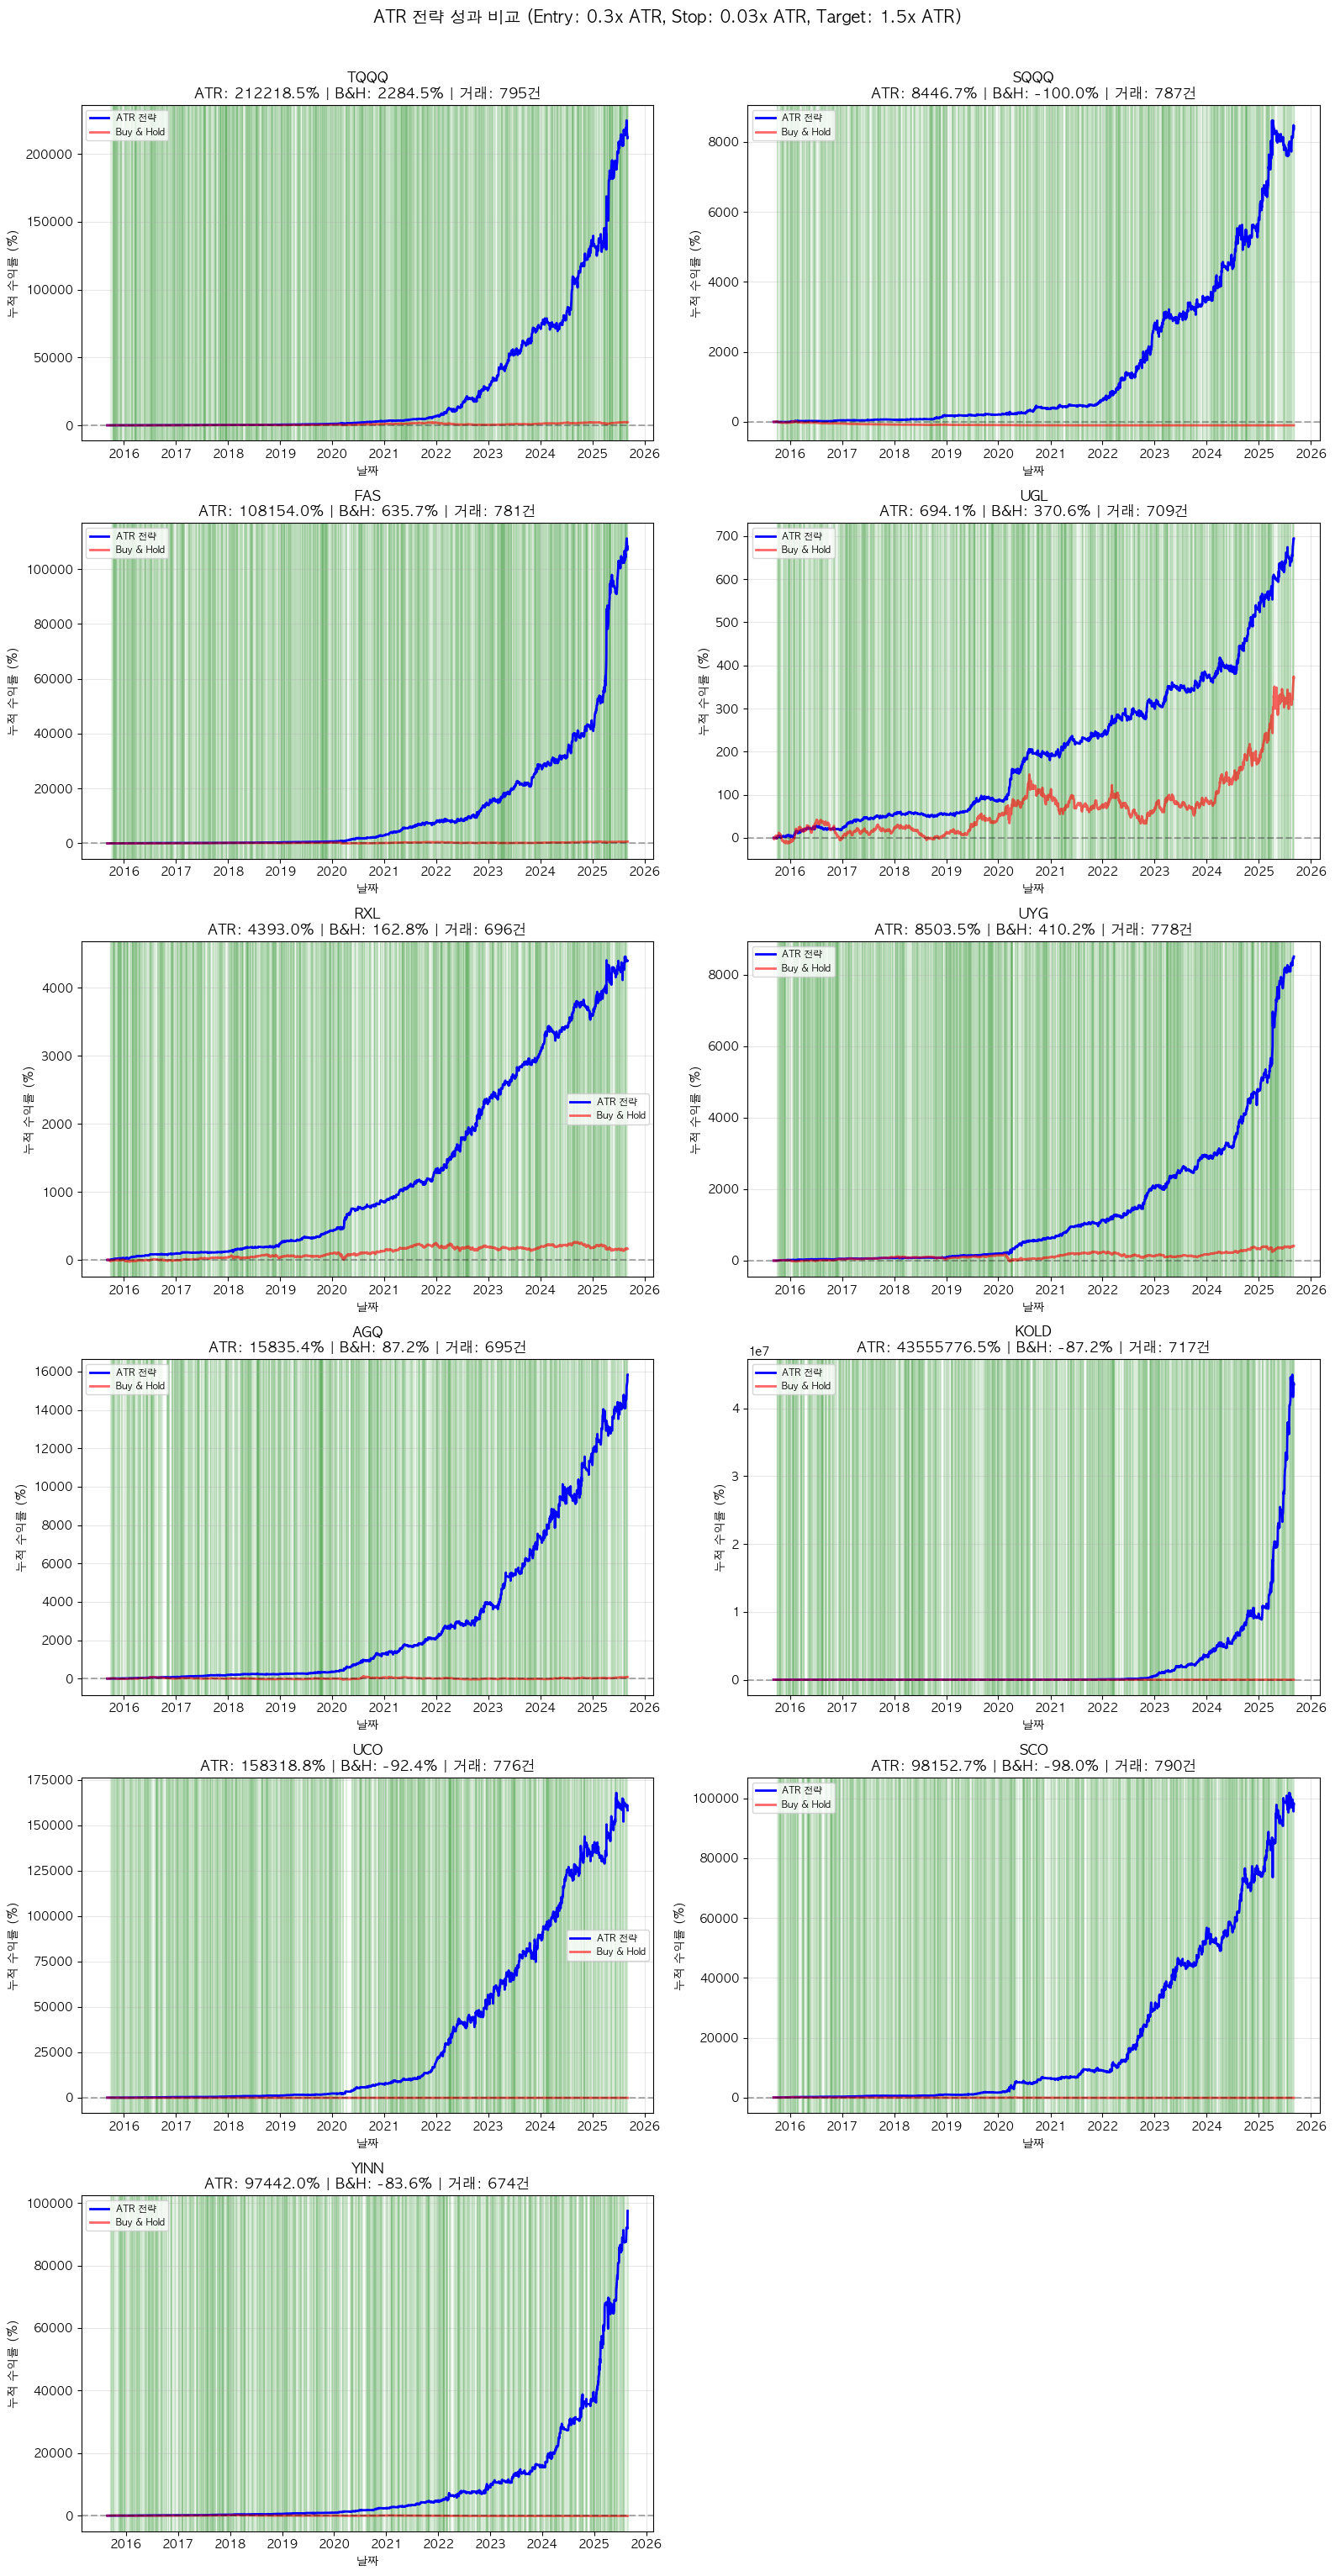


=== 전체 종목 성과 요약 ===
  종목   ATR 전략(%)  Buy&Hold(%)  ATR CAGR(%)  B&H CAGR(%)      초과수익(%)  거래횟수  승률(%)  MDD(%)  샤프비율  소르티노
KOLD 43555776.47       -87.21       266.81       -18.60 340452581.97   717   21.9   -24.7  2.63  3.86
TQQQ   212218.48      2284.49       115.29        37.36      8804.16   795   19.9   -21.8  1.99  2.48
 UCO   158318.83       -92.38       109.03       -22.72   2080138.65   776   18.4   -22.2  2.01  2.75
 FAS   108153.95       635.73       101.21        22.11     14613.90   781   20.5   -21.5  2.06  2.65
 SCO    98152.68       -98.00        99.31       -32.38   4900566.21   790   17.7   -37.2  1.64  2.37
YINN    97441.97       -83.63        99.09       -16.56    595901.00   674   20.2   -20.4  1.95  2.81
 AGQ    15835.41        87.18        66.13         6.48      8413.51   695   20.6   -11.4  1.88  2.69
 UYG     8503.47       410.19        56.16        17.72      1586.32   778   23.3   -18.9  1.84  2.33
SQQQ     8446.70       -99.96        56.09       -53.84  1929

In [118]:
# 3-2. 모든 종목의 성과 비교 그래프
# 각 종목에 대해 portfolio_df 재생성
portfolio_results = {}
for ticker, df in stock_data.items():
    trades_df, portfolio_df = backtest_atr_strategy(
        ticker, df, initial_capital,
        atr_entry_multiplier=atr_entry_multiplier,
        stop_loss_atr=stop_loss_atr,
        take_profit_atr=take_profit_atr,
        position_sizing=position_sizing,
        capital_ratio=capital_ratio
    )
    portfolio_results[ticker] = portfolio_df

# 그래프 생성
n_tickers = len(portfolio_results)
n_cols = 2
n_rows = (n_tickers + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, (ticker, portfolio_df) in enumerate(portfolio_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # ATR 전략 누적 수익률
        ax.plot(portfolio_df.index, (portfolio_df['cumulative_returns'] - 1) * 100, 
                label='ATR 전략', linewidth=2, color='blue')
        
        # Buy & Hold
        ax.plot(portfolio_df.index, (portfolio_df['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.6)
        
        # 최종 수익률 계산
        atr_final = (portfolio_df['cumulative_returns'].iloc[-1] - 1) * 100
        bh_final = (portfolio_df['buy_hold_returns'].iloc[-1] - 1) * 100
        
        # 거래 횟수 계산
        n_trades = all_results[ticker]['total_trades']
        
        ax.set_title(f'{ticker}\nATR: {atr_final:.1f}% | B&H: {bh_final:.1f}% | 거래: {n_trades}건', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        
        # 포지션 보유 기간 표시 (배경색)
        in_position = portfolio_df['position'] > 0
        for i in range(len(portfolio_df) - 1):
            if in_position.iloc[i]:
                ax.axvspan(portfolio_df.index[i], portfolio_df.index[i+1], 
                          alpha=0.1, color='green')

# 빈 서브플롯 숨기기
for idx in range(len(portfolio_results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle(f'ATR 전략 성과 비교 (Entry: {atr_entry_multiplier}x ATR, Stop: {stop_loss_atr}x ATR, Target: {take_profit_atr}x ATR)', 
             y=1.02, fontsize=14)
plt.show()

# 전체 성과 요약 테이블
summary_data = []
for ticker, results in all_results.items():
    portfolio_df = portfolio_results[ticker]
    
    # Buy & Hold CAGR 계산
    start_date = portfolio_df.index[0]
    end_date = portfolio_df.index[-1]
    years = (end_date - start_date).days / 365.25
    bh_cagr = (portfolio_df['buy_hold_returns'].iloc[-1]) ** (1 / years) - 1
    
    summary_data.append({
        '종목': ticker,
        'ATR 전략(%)': round((portfolio_df['cumulative_returns'].iloc[-1] - 1) * 100, 2),
        'Buy&Hold(%)': round((portfolio_df['buy_hold_returns'].iloc[-1] - 1) * 100, 2),
        'ATR CAGR(%)': round(results['cagr'] * 100, 2),
        'B&H CAGR(%)': round(bh_cagr * 100, 2),
        '초과수익(%)': round((portfolio_df['strategy_vs_buyhold'].iloc[-1] - 1) * 100, 2),
        '거래횟수': results['total_trades'],
        '승률(%)': round(results.get('win_rate', 0) * 100, 1),
        'MDD(%)': round(results['max_drawdown'] * 100, 1),
        '샤프비율': round(results['sharpe_ratio'], 2),
        '소르티노': round(results.get('sortino_ratio', 0), 2)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('ATR 전략(%)', ascending=False)

print("\n=== 전체 종목 성과 요약 ===")
print(summary_df.to_string(index=False))

# 평균 성과 계산
print(f"\n=== 평균 성과 ===")
print(f"평균 ATR 전략 수익률: {summary_df['ATR 전략(%)'].mean():.2f}%")
print(f"평균 Buy&Hold 수익률: {summary_df['Buy&Hold(%)'].mean():.2f}%")
print(f"평균 ATR CAGR: {summary_df['ATR CAGR(%)'].mean():.2f}%")
print(f"평균 Buy&Hold CAGR: {summary_df['B&H CAGR(%)'].mean():.2f}%")
print(f"평균 초과 수익률: {summary_df['초과수익(%)'].mean():.2f}%")
print(f"평균 거래 횟수: {summary_df['거래횟수'].mean():.1f}")
print(f"평균 승률: {summary_df['승률(%)'].mean():.1f}%")
print(f"평균 샤프비율: {summary_df['샤프비율'].mean():.2f}")
print(f"평균 소르티노비율: {summary_df['소르티노'].mean():.2f}")

# 샤프비율과 소르티노비율 비교
print(f"\n=== 위험조정 수익률 비교 ===")
for ticker in summary_df['종목']:
    sharpe = all_results[ticker]['sharpe_ratio']
    sortino = all_results[ticker].get('sortino_ratio', 0)
    cagr = all_results[ticker]['cagr']
    print(f"{ticker}: 샤프 {sharpe:.2f} | 소르티노 {sortino:.2f} | 차이 {sortino-sharpe:.2f} | CAGR {cagr:.1%}")

### 6.1. 포트폴리오 통합 성과 분석

In [121]:
# 포트폴리오 통합 백테스트 실행
print("=== 포트폴리오 통합 백테스트 ===")
print(f"종목 수: {len(stock_data)}개")
print(f"초기 자본: ${initial_capital:,}")

# 균등 배분 포트폴리오
print("\n1. 균등 배분 포트폴리오")
integrated_trades, integrated_portfolio, ticker_results, integrated_results = portfolio_integrated_backtest(
    stock_data,
    initial_capital=initial_capital,
    atr_entry_multiplier=atr_entry_multiplier,
    stop_loss_atr=stop_loss_atr,
    take_profit_atr=take_profit_atr,
    allocation_method='equal'
)

print(f"\n통합 포트폴리오 성과:")
print(f"- 최종 포트폴리오 가치: ${integrated_results['final_portfolio_value']:,.2f}")
print(f"- 총 수익률: {integrated_results['total_return']:.2%}")
print(f"- CAGR: {integrated_results['cagr']:.2%}")
print(f"- 샤프 비율: {integrated_results['sharpe_ratio']:.2f}")
print(f"- 소르티노 비율: {integrated_results.get('sortino_ratio', 0):.2f}")  # get 메서드로 안전하게 접근
print(f"- 최대 낙폭: {integrated_results['max_drawdown']:.2%}")
print(f"- 총 거래 수: {integrated_results['total_trades']}")

# 종목별 할당 비중 출력
print(f"\n종목별 자본 할당:")
for ticker, results in ticker_results.items():
    allocation = results['allocation']
    print(f"- {ticker}: {allocation:.1%} (${allocation * initial_capital:,.0f})")

# 변동성 가중 포트폴리오
# print("\n2. 변동성 가중 포트폴리오")
# vol_weighted_trades, vol_weighted_portfolio, vol_ticker_results, vol_weighted_results = portfolio_integrated_backtest(
#     stock_data,
#     initial_capital=initial_capital,
#     atr_entry_multiplier=atr_entry_multiplier,
#     stop_loss_atr=stop_loss_atr,
#     take_profit_atr=take_profit_atr,
#     allocation_method='volatility_weighted',
#     capital_ratio=capital_ratio,
#     position_sizing=position_sizing
# )

# print(f"\n통합 포트폴리오 성과:")
# print(f"- 최종 포트폴리오 가치: ${vol_weighted_results['final_portfolio_value']:,.2f}")
# print(f"- 총 수익률: {vol_weighted_results['total_return']:.2%}")
# print(f"- CAGR: {vol_weighted_results['cagr']:.2%}")
# print(f"- 샤프 비율: {vol_weighted_results['sharpe_ratio']:.2f}")
# print(f"- 소르티노 비율: {vol_weighted_results.get('sortino_ratio', 0):.2f}")  # get 메서드로 안전하게 접근
# print(f"- 최대 낙폭: {vol_weighted_results['max_drawdown']:.2%}")

# print(f"\n변동성 가중 종목별 자본 할당:")
# for ticker, results in vol_ticker_results.items():
#     allocation = results['allocation']
#     print(f"- {ticker}: {allocation:.1%} (${allocation * initial_capital:,.0f})")

# 통합 포트폴리오 vs 개별 종목 성과 비교
print("\n=== 통합 포트폴리오 vs 개별 종목 성과 ===")
print(f"{'구분':<15} {'수익률':>12} {'CAGR':>8} {'샤프비율':>10} {'MDD':>10}")
print("-" * 60)

# 통합 포트폴리오
print(f"{'균등배분 포트':.<15} {integrated_results['total_return']:>11.1%} {integrated_results['cagr']:>7.1%} {integrated_results['sharpe_ratio']:>10.2f} {integrated_results['max_drawdown']:>9.1%}")
# print(f"{'변동성가중 포트':.<15} {vol_weighted_results['total_return']:>11.1%} {vol_weighted_results['cagr']:>7.1%} {vol_weighted_results['sharpe_ratio']:>10.2f} {vol_weighted_results['max_drawdown']:>9.1%}")

# 개별 종목
for ticker, results in all_results.items():
    print(f"{ticker:.<15} {results['total_return']:>11.1%} {results['cagr']:>7.1%} {results['sharpe_ratio']:>10.2f} {results['max_drawdown']:>9.1%}")

# Buy & Hold 포트폴리오와 비교
bh_return = (integrated_portfolio['buy_hold_returns'].iloc[-1] - 1)
# Buy & Hold CAGR 계산
start_date = integrated_portfolio.index[0]
end_date = integrated_portfolio.index[-1]
years = (end_date - start_date).days / 365.25
bh_cagr = (1 + bh_return) ** (1 / years) - 1

print(f"\n{'Buy&Hold 포트':.<15} {bh_return:>11.1%} {bh_cagr:>7.1%}")

print(f"\n포트폴리오 초과 수익률:")
print(f"- 균등배분: {integrated_results['total_return'] - bh_return:.1%} (CAGR 초과: {integrated_results['cagr'] - bh_cagr:.1%})")
# print(f"- 변동성가중: {vol_weighted_results['total_return'] - bh_return:.1%} (CAGR 초과: {vol_weighted_results['cagr'] - bh_cagr:.1%})")

=== 포트폴리오 통합 백테스트 ===
종목 수: 11개
초기 자본: $100,000

1. 균등 배분 포트폴리오

통합 포트폴리오 성과:
- 최종 포트폴리오 가치: $3,943,884,300.97
- 총 수익률: 3943784.30%
- CAGR: 187.18%
- 샤프 비율: 2.98
- 소르티노 비율: 3.66
- 최대 낙폭: -17.62%
- 총 거래 수: 8018

종목별 자본 할당:
- TQQQ: 9.1% ($9,091)
- SQQQ: 9.1% ($9,091)
- FAS: 9.1% ($9,091)
- UGL: 9.1% ($9,091)
- RXL: 9.1% ($9,091)
- UYG: 9.1% ($9,091)
- AGQ: 9.1% ($9,091)
- KOLD: 9.1% ($9,091)
- UCO: 9.1% ($9,091)
- SCO: 9.1% ($9,091)
- YINN: 9.1% ($9,091)

=== 통합 포트폴리오 vs 개별 종목 성과 ===
구분                       수익률     CAGR       샤프비율        MDD
------------------------------------------------------------
균등배분 포트........  3943784.3%  187.2%       2.98    -17.6%
TQQQ...........   212218.5%  115.3%       1.99    -21.8%
SQQQ...........     8446.7%   56.1%       1.30    -17.0%
FAS............   107937.3%  101.2%       2.06    -21.5%
UGL............      694.1%   23.0%       1.27     -8.3%
RXL............     4384.0%   46.3%       1.91     -9.9%
UYG............     8486.3%   56.2%       1.84    

## 7. 상대모멘텀 전략 백테스트

In [124]:
# 상대모멘텀 + ATR 전략 백테스트
print("=== 상대모멘텀 + ATR 전략 백테스트 ===")

# 파라미터 설정
momentum_params = {
    'lookback_period': 20,  # 20일 모멘텀
    'top_n': 3,  # 상위 3개 종목 선택
    'rebalance_freq': 'monthly',  # 월별 리밸런싱
    'atr_entry_multiplier': 0.3,
    'stop_loss_atr': 0.03,
    'take_profit_atr': 1.5,
    'capital_ratio': 1.0,
    'position_sizing': 1.0
}

# 상대모멘텀 전략 실행
momentum_trades_df, momentum_portfolio_df, selected_tickers_df, momentum_scores_df = backtest_relative_momentum_atr_strategy(
    stock_data,
    initial_capital=initial_capital,
    **momentum_params
)

# 결과 분석
momentum_results = analyze_backtest_results(momentum_trades_df, momentum_portfolio_df, initial_capital)

print(f"\n상대모멘텀 전략 성과:")
print(f"- 최종 포트폴리오 가치: ${momentum_results['final_portfolio_value']:,.2f}")
print(f"- 총 수익률: {momentum_results['total_return']:.2%}")
print(f"- CAGR: {momentum_results['cagr']:.2%}")
print(f"- 샤프 비율: {momentum_results['sharpe_ratio']:.2f}")
print(f"- 소르티노 비율: {momentum_results.get('sortino_ratio', 0):.2f}")
print(f"- 최대 낙폭: {momentum_results['max_drawdown']:.2%}")
print(f"- 총 거래 수: {momentum_results['total_trades']}")

# 리밸런싱 빈도
print(f"\n리밸런싱 정보:")
print(f"- 총 리밸런싱 횟수: {len(selected_tickers_df)}")
print(f"- 리밸런싱 주기: {momentum_params['rebalance_freq']}")

# 최근 선택된 종목들
print(f"\n최근 선택된 종목 (최근 5개월):")
recent_selections = selected_tickers_df.tail(5)
for date, row in recent_selections.iterrows():
    selected = [str(ticker) for ticker in row.dropna().values]
    print(f"{date.strftime('%Y-%m-%d')}: {', '.join(selected)}")

# 종목별 선택 빈도
ticker_selection_count = {}
for _, row in selected_tickers_df.iterrows():
    for ticker in row.dropna():
        ticker_selection_count[ticker] = ticker_selection_count.get(ticker, 0) + 1

print(f"\n종목별 선택 빈도:")
sorted_selection = sorted(ticker_selection_count.items(), key=lambda x: x[1], reverse=True)
for ticker, count in sorted_selection[:10]:
    selection_rate = count / len(selected_tickers_df) * 100
    print(f"- {ticker}: {count}회 ({selection_rate:.1f}%)")

=== 상대모멘텀 + ATR 전략 백테스트 ===

상대모멘텀 전략 성과:
- 최종 포트폴리오 가치: $168,951.53
- 총 수익률: 68.95%
- CAGR: 5.37%
- 샤프 비율: 0.73
- 소르티노 비율: 1.47
- 최대 낙폭: -3.36%
- 총 거래 수: 137

리밸런싱 정보:
- 총 리밸런싱 횟수: 78
- 리밸런싱 주기: monthly

최근 선택된 종목 (최근 5개월):
2025-03-03: YINN, SQQQ, SCO
2025-04-01: KOLD, UGL, SQQQ
2025-06-02: TQQQ, AGQ, UCO
2025-07-01: YINN, KOLD, TQQQ
2025-09-02: AGQ, UGL, FAS

종목별 선택 빈도:
- TQQQ: 36회 (46.2%)
- UCO: 29회 (37.2%)
- KOLD: 28회 (35.9%)
- FAS: 27회 (34.6%)
- SQQQ: 21회 (26.9%)
- AGQ: 21회 (26.9%)
- SCO: 18회 (23.1%)
- YINN: 18회 (23.1%)
- UGL: 14회 (17.9%)
- RXL: 13회 (16.7%)


### 7.1 상대모멘텀 전략 시각화

In [125]:
# ATR 전략 수익률 기반 상대모멘텀 포트폴리오
print("=== ATR 전략 수익률 기반 상대모멘텀 포트폴리오 ===")

# 파라미터 설정
momentum_params = {
    'lookback_period': 20,  # 20일 모멘텀
    'top_n': 3,  # 상위 3개 종목 선택
    'rebalance_freq': 'monthly',  # 월별 리밸런싱
}

# 상대모멘텀 포트폴리오 구성
momentum_portfolio_df, selected_tickers_df, momentum_scores_df, weights_df = relative_momentum_portfolio_selection(
    all_results,
    portfolio_results,
    initial_capital=initial_capital,
    **momentum_params
)

# 결과 분석
momentum_results = analyze_backtest_results(pd.DataFrame(), momentum_portfolio_df, initial_capital)

print(f"\nATR 전략 기반 상대모멘텀 포트폴리오 성과:")
print(f"- 최종 포트폴리오 가치: ${momentum_results['final_portfolio_value']:,.2f}")
print(f"- 총 수익률: {momentum_results['total_return']:.2%}")
print(f"- CAGR: {momentum_results['cagr']:.2%}")
print(f"- 샤프 비율: {momentum_results['sharpe_ratio']:.2f}")
print(f"- 소르티노 비율: {momentum_results.get('sortino_ratio', 0):.2f}")
print(f"- 최대 낙폭: {momentum_results['max_drawdown']:.2%}")

# ATR 전략 균등 포트폴리오 (벤치마크)와 비교
bh_return = (momentum_portfolio_df['buy_hold_returns'].iloc[-1] - 1)
bh_cagr = (momentum_portfolio_df['buy_hold_returns'].iloc[-1]) ** (1 / ((momentum_portfolio_df.index[-1] - momentum_portfolio_df.index[0]).days / 365.25)) - 1

print(f"\n벤치마크 (ATR 전략 균등 포트폴리오):")
print(f"- 총 수익률: {bh_return:.2%}")
print(f"- CAGR: {bh_cagr:.2%}")

print(f"\n초과 성과:")
print(f"- 수익률 차이: {momentum_results['total_return'] - bh_return:.2%}p")
print(f"- CAGR 차이: {(momentum_results['cagr'] - bh_cagr)*100:.2f}%p")

# 리밸런싱 정보
print(f"\n리밸런싱 정보:")
print(f"- 총 리밸런싱 횟수: {len(selected_tickers_df)}")
print(f"- 리밸런싱 주기: {momentum_params['rebalance_freq']}")

# 최근 선택된 종목들
print(f"\n최근 선택된 종목 (최근 5개월):")
if not selected_tickers_df.empty:
    recent_selections = selected_tickers_df.tail(5)
    for date, row in recent_selections.iterrows():
        selected = [str(ticker) for ticker in row.dropna().values]
        momentum_scores_on_date = momentum_scores_df.loc[date]
        scores_str = ", ".join([f"{ticker}({momentum_scores_on_date[ticker]:.1%})" for ticker in selected])
        print(f"{date.strftime('%Y-%m-%d')}: {scores_str}")

# 종목별 선택 빈도
ticker_selection_count = {}
for _, row in selected_tickers_df.iterrows():
    for ticker in row.dropna():
        ticker_selection_count[ticker] = ticker_selection_count.get(ticker, 0) + 1

print(f"\n종목별 선택 빈도:")
sorted_selection = sorted(ticker_selection_count.items(), key=lambda x: x[1], reverse=True)
for ticker, count in sorted_selection:
    selection_rate = count / len(selected_tickers_df) * 100
    print(f"- {ticker}: {count}회 ({selection_rate:.1f}%)")

=== ATR 전략 수익률 기반 상대모멘텀 포트폴리오 ===

ATR 전략 기반 상대모멘텀 포트폴리오 성과:
- 최종 포트폴리오 가치: $14,526,786,193.40
- 총 수익률: 14526686.19%
- CAGR: 227.04%
- 샤프 비율: 0.57
- 소르티노 비율: 59.63
- 최대 낙폭: -99.83%

벤치마크 (ATR 전략 균등 포트폴리오):
- 총 수익률: 4015439.39%
- CAGR: 187.69%

초과 성과:
- 수익률 차이: 10511246.81%p
- CAGR 차이: 39.34%p

리밸런싱 정보:
- 총 리밸런싱 횟수: 119
- 리밸런싱 주기: monthly

최근 선택된 종목 (최근 5개월):
2025-05-01: FAS(45.6%), KOLD(42.0%), TQQQ(37.3%)
2025-06-02: KOLD(23.6%), AGQ(7.0%), UYG(6.7%)
2025-07-01: YINN(25.8%), KOLD(20.9%), FAS(8.4%)
2025-08-01: KOLD(17.5%), SCO(3.3%), YINN(2.9%)
2025-09-02: AGQ(8.8%), KOLD(8.1%), SQQQ(7.4%)

종목별 선택 빈도:
- KOLD: 65회 (54.6%)
- FAS: 44회 (37.0%)
- TQQQ: 42회 (35.3%)
- SCO: 40회 (33.6%)
- YINN: 39회 (32.8%)
- UCO: 39회 (32.8%)
- AGQ: 31회 (26.1%)
- SQQQ: 25회 (21.0%)
- UYG: 16회 (13.4%)
- RXL: 11회 (9.2%)
- UGL: 5회 (4.2%)


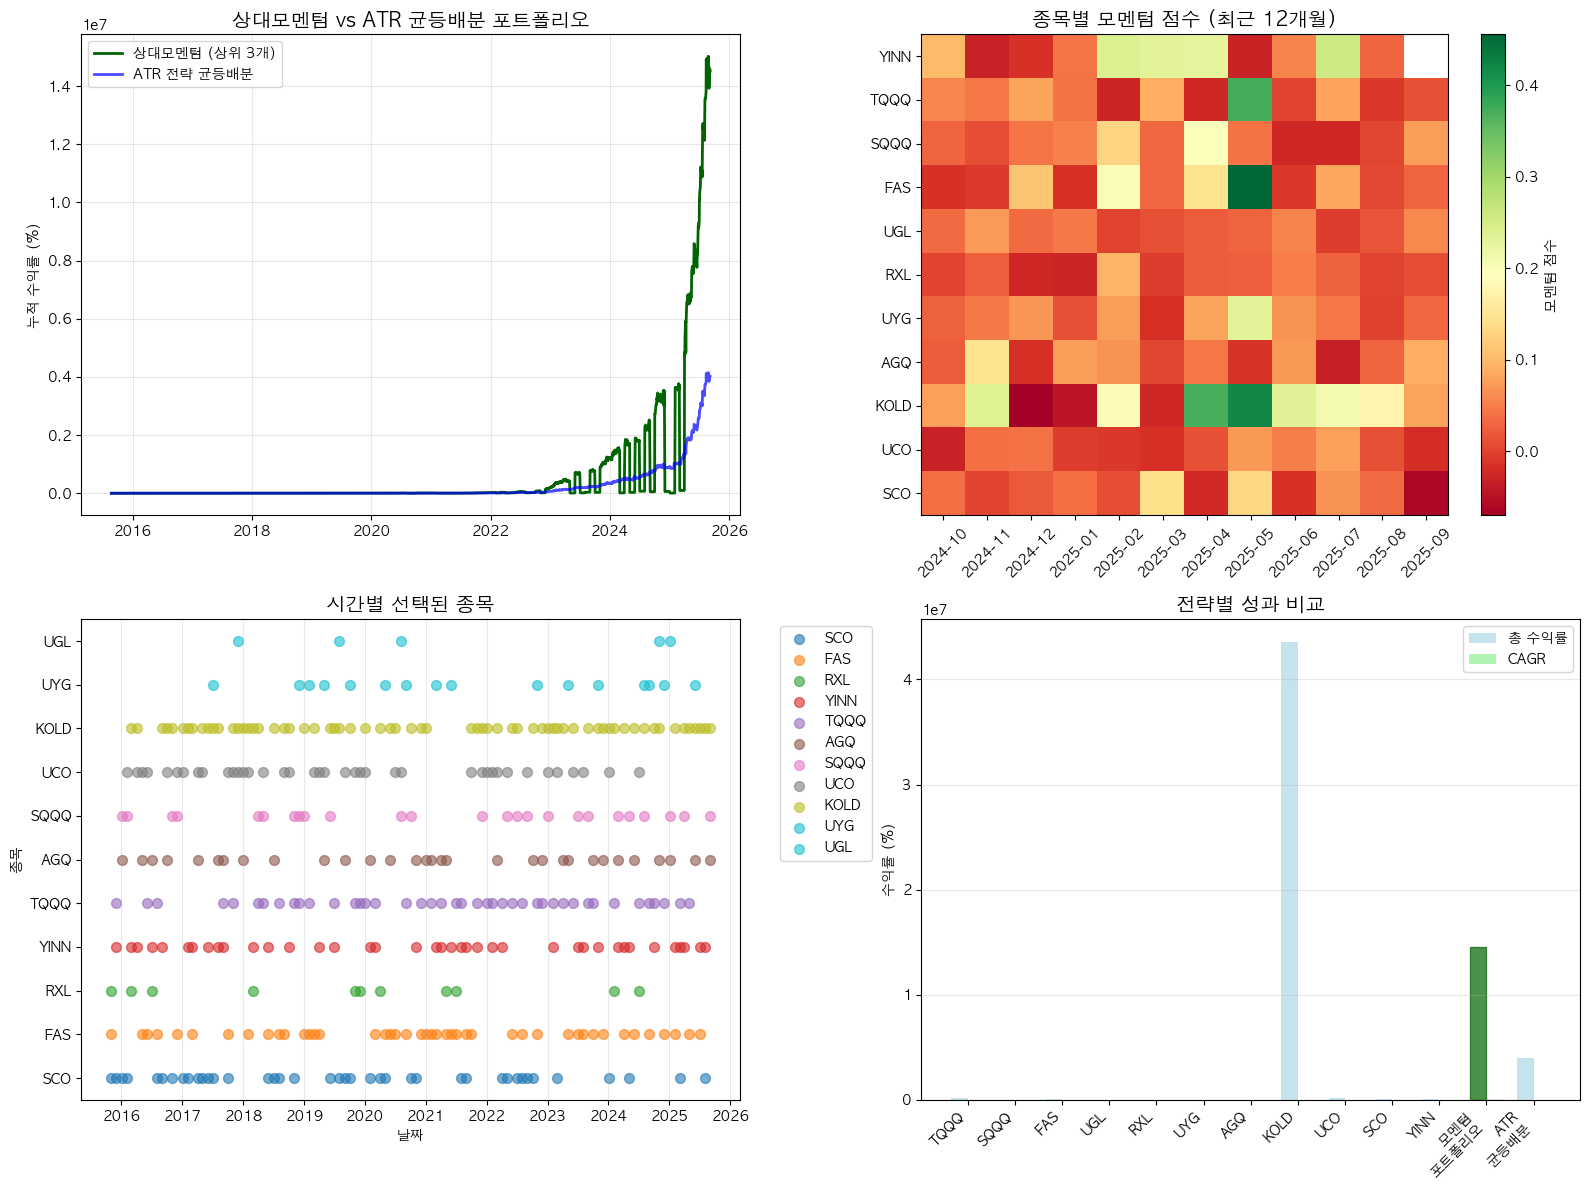


=== 상대모멘텀 전략 상세 분석 ===

월별 성과:
- 상승 월: 71개월 (59.7%)
- 하락 월: 48개월 (40.3%)
- 평균 월 수익률: 903.21%
- 최고 월 수익률: 55924.98%
- 최저 월 수익률: -99.26%

연도별 성과:
- 2015년: 49.62%
- 2016년: 80.63%
- 2017년: 101.31%
- 2018년: -38.90%
- 2019년: 316.85%
- 2020년: 499.72%
- 2021년: 205.86%
- 2022년: 702.22%
- 2023년: 485.43%
- 2024년: -94.94%
- 2025년: 23956.06%

리스크 지표:
- 일별 변동성: 18394.08%
- 월별 변동성: 18604.54%
- 최대 연속 하락일: 1089일


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_49588/4227801844.py:115: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = momentum_portfolio_df['daily_returns'].resample('M').apply(lambda x: (1 + x).prod() - 1)
/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_49588/4227801844.py:127: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = momentum_portfolio_df['daily_returns'].resample('Y').apply(lambda x: (1 + x).prod() - 1)


In [126]:
# 상대모멘텀 전략 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 모멘텀 포트폴리오 vs 벤치마크 성과 비교
ax1 = axes[0, 0]
ax1.plot(momentum_portfolio_df.index, (momentum_portfolio_df['cumulative_returns'] - 1) * 100, 
         label='상대모멘텀 (상위 3개)', linewidth=2, color='darkgreen')
ax1.plot(momentum_portfolio_df.index, (momentum_portfolio_df['buy_hold_returns'] - 1) * 100, 
         label='ATR 전략 균등배분', linewidth=2, color='blue', alpha=0.7)
ax1.set_title('상대모멘텀 vs ATR 균등배분 포트폴리오', fontsize=14)
ax1.set_ylabel('누적 수익률 (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 종목별 모멘텀 점수 히트맵
ax2 = axes[0, 1]
if not momentum_scores_df.empty:
    # 최근 12개월 데이터만
    recent_scores = momentum_scores_df.tail(12)
    
    # 히트맵 데이터 준비
    heatmap_data = recent_scores.T
    
    # 히트맵 그리기
    im = ax2.imshow(heatmap_data.values, aspect='auto', cmap='RdYlGn', interpolation='nearest')
    
    # x축 (날짜)
    ax2.set_xticks(range(len(recent_scores)))
    ax2.set_xticklabels([date.strftime('%Y-%m') for date in recent_scores.index], rotation=45)
    
    # y축 (종목)
    ax2.set_yticks(range(len(heatmap_data)))
    ax2.set_yticklabels(heatmap_data.index)
    
    # 컬러바
    plt.colorbar(im, ax=ax2, label='모멘텀 점수')
    
    ax2.set_title('종목별 모멘텀 점수 (최근 12개월)', fontsize=14)

# 3. 선택된 종목 변화
ax3 = axes[1, 0]
if not selected_tickers_df.empty:
    # 종목별 선택 시점 표시
    ticker_selection_timeline = {}
    
    for date, row in selected_tickers_df.iterrows():
        for rank, ticker in enumerate(row.dropna()):
            if ticker not in ticker_selection_timeline:
                ticker_selection_timeline[ticker] = {'dates': [], 'ranks': []}
            ticker_selection_timeline[ticker]['dates'].append(date)
            ticker_selection_timeline[ticker]['ranks'].append(rank + 1)
    
    # 각 종목별로 선택된 시점 플롯
    colors = plt.cm.tab10(np.linspace(0, 1, len(ticker_selection_timeline)))
    
    for i, (ticker, data) in enumerate(ticker_selection_timeline.items()):
        ax3.scatter(data['dates'], [ticker] * len(data['dates']), 
                   c=[colors[i]], s=50, alpha=0.6, label=ticker)
    
    ax3.set_xlabel('날짜')
    ax3.set_ylabel('종목')
    ax3.set_title('시간별 선택된 종목', fontsize=14)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3, axis='x')

# 4. 상대 성과 비교
ax4 = axes[1, 1]

# 개별 종목 ATR 전략 성과
atr_returns = []
atr_cagrs = []
tickers = []

for ticker, results in all_results.items():
    tickers.append(ticker)
    atr_returns.append(results['total_return'])
    atr_cagrs.append(results['cagr'])

# 모멘텀 포트폴리오 추가
tickers.append('모멘텀\n포트폴리오')
atr_returns.append(momentum_results['total_return'])
atr_cagrs.append(momentum_results['cagr'])

# 균등 포트폴리오 추가
tickers.append('ATR\n균등배분')
atr_returns.append(bh_return)
atr_cagrs.append(bh_cagr)

x = np.arange(len(tickers))
width = 0.35

bars1 = ax4.bar(x - width/2, [r*100 for r in atr_returns], width, 
                label='총 수익률', alpha=0.7, color='lightblue')
bars2 = ax4.bar(x + width/2, [c*100 for c in atr_cagrs], width, 
                label='CAGR', alpha=0.7, color='lightgreen')

# 모멘텀 포트폴리오 강조
bars1[-2].set_color('darkgreen')
bars2[-2].set_color('darkgreen')

ax4.set_ylabel('수익률 (%)')
ax4.set_title('전략별 성과 비교', fontsize=14)
ax4.set_xticks(x)
ax4.set_xticklabels(tickers, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 추가 분석: 모멘텀 전략의 안정성
print("\n=== 상대모멘텀 전략 상세 분석 ===")

# 월별 수익률 분석
monthly_returns = momentum_portfolio_df['daily_returns'].resample('M').apply(lambda x: (1 + x).prod() - 1)
positive_months = (monthly_returns > 0).sum()
negative_months = (monthly_returns < 0).sum()

print(f"\n월별 성과:")
print(f"- 상승 월: {positive_months}개월 ({positive_months/(positive_months+negative_months)*100:.1f}%)")
print(f"- 하락 월: {negative_months}개월 ({negative_months/(positive_months+negative_months)*100:.1f}%)")
print(f"- 평균 월 수익률: {monthly_returns.mean():.2%}")
print(f"- 최고 월 수익률: {monthly_returns.max():.2%}")
print(f"- 최저 월 수익률: {monthly_returns.min():.2%}")

# 연도별 성과
yearly_returns = momentum_portfolio_df['daily_returns'].resample('Y').apply(lambda x: (1 + x).prod() - 1)
print(f"\n연도별 성과:")
for year, ret in yearly_returns.items():
    print(f"- {year.year}년: {ret:.2%}")

# 리스크 분석
print(f"\n리스크 지표:")
print(f"- 일별 변동성: {momentum_portfolio_df['daily_returns'].std() * np.sqrt(252):.2%}")
print(f"- 월별 변동성: {monthly_returns.std() * np.sqrt(12):.2%}")
print(f"- 최대 연속 하락일: {(momentum_portfolio_df['daily_returns'] < 0).rolling(window=len(momentum_portfolio_df)).sum().max():.0f}일")

## 6. 최적 파라미터 탐색

In [88]:
# 파라미터 그리드 설정
param_grid = {
    'atr_entry': [0.3, 0.5, 0.7, 0.9, 1],
    'stop_loss': [0.03, 0.05, 0.1, 0.15],
    'take_profit': [1,1, 1,2, 1,3, 1,4, 1,5, 2.0, 3.0, 4.0, 5.0]
}

# 첫 번째 종목으로 파라미터 테스트
test_ticker = list(stock_data.keys())[0]
test_df = stock_data[test_ticker]

print(f"\n{test_ticker} 종목으로 파라미터 최적화 진행...")

best_params = None
best_sharpe = -float('inf')
param_results = []

for atr_entry in param_grid['atr_entry']:
    for stop_loss in param_grid['stop_loss']:
        for take_profit in param_grid['take_profit']:
            # 손절선이 익절선보다 큰 경우는 스킵
            if stop_loss >= take_profit:
                continue
            
            # 백테스트 실행
            trades_df, portfolio_df = backtest_atr_strategy(
                test_ticker, test_df, initial_capital,
                atr_entry_multiplier=atr_entry,
                stop_loss_atr=stop_loss,
                take_profit_atr=take_profit
            )
            
            # 결과 분석
            results = analyze_backtest_results(trades_df, portfolio_df, initial_capital)
            
            param_results.append({
                'atr_entry': atr_entry,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'total_return': results['total_return'],
                'sharpe_ratio': results['sharpe_ratio'],
                'max_drawdown': results['max_drawdown'],
                'total_trades': results['total_trades'],
                'win_rate': results.get('win_rate', 0)
            })
            
            # 최적 파라미터 업데이트 (샤프비율 기준)
            if results['sharpe_ratio'] > best_sharpe:
                best_sharpe = results['sharpe_ratio']
                best_params = {
                    'atr_entry': atr_entry,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'results': results
                }

# 결과 DataFrame 생성 및 정렬
param_results_df = pd.DataFrame(param_results)
param_results_df = param_results_df.sort_values('sharpe_ratio', ascending=False)

print("\n=== 최적 파라미터 ===")
print(f"ATR 진입 배수: {best_params['atr_entry']}")
print(f"손절선 ATR 배수: {best_params['stop_loss']}")
print(f"익절선 ATR 배수: {best_params['take_profit']}")
print(f"\n성과:")
print(f"- 수익률: {best_params['results']['total_return']:.2%}")
print(f"- 샤프비율: {best_params['results']['sharpe_ratio']:.2f}")
print(f"- 최대낙폭: {best_params['results']['max_drawdown']:.2%}")
print(f"- 승률: {best_params['results'].get('win_rate', 0):.2%}")

# 상위 10개 파라미터 조합 출력
print("\n=== 상위 10개 파라미터 조합 ===")
print(param_results_df.head(10).to_string(index=False))


TQQQ 종목으로 파라미터 최적화 진행...

=== 최적 파라미터 ===
ATR 진입 배수: 0.3
손절선 ATR 배수: 0.03
익절선 ATR 배수: 3

성과:
- 수익률: 7638.87%
- 샤프비율: 1.85
- 최대낙폭: -15.61%
- 승률: 14.10%

=== 상위 10개 파라미터 조합 ===
 atr_entry  stop_loss  take_profit  total_return  sharpe_ratio  max_drawdown  total_trades  win_rate
       0.3       0.03          3.0     76.388655      1.845214     -0.156067           603  0.140962
       0.3       0.03          3.0     76.388655      1.845214     -0.156067           603  0.140962
       0.5       0.05          3.0     41.971914      1.815588     -0.150862           458  0.155022
       0.5       0.05          3.0     41.971914      1.815588     -0.150862           458  0.155022
       0.5       0.03          2.0     28.274803      1.805646     -0.146513           566  0.174912
       0.5       0.03          2.0     28.274803      1.805646     -0.146513           566  0.174912
       0.5       0.03          3.0     39.786530      1.798325     -0.146511           473  0.143763
       0.5      